### Wages for Group, Any Job Status

In [1]:
# Import preliminaries
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools
mpl.rc('axes', edgecolor='white') # Hide the axes
plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)
plt.rc('legend',fontsize=9)

from pathlib import Path

cps_dir = Path('/home/brian/Documents/CPS/data/clean/')

# Recession start and end months, from NBER
rec_dt = [('1969-12-01', '1970-11-01'), ('1973-11-01', '1975-03-01'), 
          ('1980-01-01', '1980-07-01'), ('1981-07-01', '1982-11-01'),
          ('1990-07-01', '1991-03-01'), ('2001-04-01', '2001-12-01'), 
          ('2008-01-01', '2009-07-01'), ('2020-02-01', '2020-04-01')]

In [2]:
def binned_wage(df, wage_var='RWKEARN', percentile=0.5, wgt_var='PWORWGT',
                bins=np.arange(-25, 3000, 50)):
    '''
    Returns wage estimate based on linear interpolation through 
    the bin containing the wage.
    
    perc = percentile of interest (0.5 is median)
    bins = list of bin start locations
    '''
    cdf = (df.groupby(pd.cut(df[wage_var], bins))
             [wgt_var].sum().cumsum() / df[wgt_var].sum())
    
    return np.interp(percentile, cdf, bins[1:])

In [3]:
# Collect CPS data
years = range(2014, 2024)
cols = ['CPSID', 'MONTH', 'YEAR', 'AGE', 'FEMALE', 'WBHAO', 'EDUC', 'WORKFT',
        'PWORWGT', 'PWSSWGT', 'LFS', 'HRSACTT', 'HRSUSL1', 'REGION', 'USLFT',
        'OCC03D', 'COW1', 'HRWAGE', 'WKEARN', 'MIS', 'FAMNUM', 'PRICEADJ']

self_emp = ["Self-employed Unincorporated", "Self-employed Incorporated"]

formula = 'HRWAGE ~ AGE + EDUC + WBHAO + C(OCC03D) + REGION + USLFT'

#ft = lambda x: np.where(x.HRSUSL1 >= 35, 1, 0)
se = lambda x: np.where(x.COW1.isin(self_emp), 1, 0)

df = pd.concat([pd.read_feather(cps_dir / f'cps{year}.ft', columns=cols)
                  .query('PWORWGT > 0')
                  .assign(SE = se)
                 for year in years])

# Date from Year, Month
df['DATE'] = pd.to_datetime(dict(year=df.YEAR, 
                                 month=df.MONTH, day=1))

quarters = [[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]]
dfi = pd.DataFrame()
for year, mo_list in itertools.product(years, quarters):
    dfm = df.copy().query('YEAR == @year and MONTH in @mo_list')
    dfm['Quarter'] = f'{year}Q{mo_list[-1]/3:.0f}'
    reg = {}
    for fem in [0, 1]:
        mod = smf.quantreg(formula, dfm.query('HRWAGE > 0 and FEMALE == @fem'))
        reg[fem] = mod.fit(q=.5)

        # fill self-employed wage with predicted wage
        query = 'SE == 1 and FEMALE == @fem'
        se_wkwage = reg[fem].predict(dfm.query(query)) * dfm.query(query).HRSACTT
        dfm.loc[se_wkwage.index, 'WKEARN'] = se_wkwage
        dfi = pd.concat([dfi, dfm])
        
dfi['RWKEARN'] = (dfi['WKEARN'] * dfi['PRICEADJ']).fillna(0)

/home/brian/miniconda3/lib/python3.8/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/home/brian/miniconda3/lib/python3.8/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/home/brian/miniconda3/lib/python3.8/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/home/brian/miniconda3/lib/python3.8/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/home/brian/miniconda3/lib/python3.8/site-packages/s

In [4]:
# Calculate median
female = [0, 1]
age = [(25, 34), (35, 44), (45, 54)]
res = pd.DataFrame()
for fem, (age1, age2) in itertools.product(female, age):
    sex = 'Women' if fem == 1 else 'Men'
    name = f'{sex}, {age1} to {age2}' 
    res[name] = (dfi.query('@age1 <= AGE <= @age2 and FEMALE == @fem')
                    .groupby('Quarter').apply(binned_wage))
    
res.index = pd.to_datetime(res.index)
res.index.name = ''

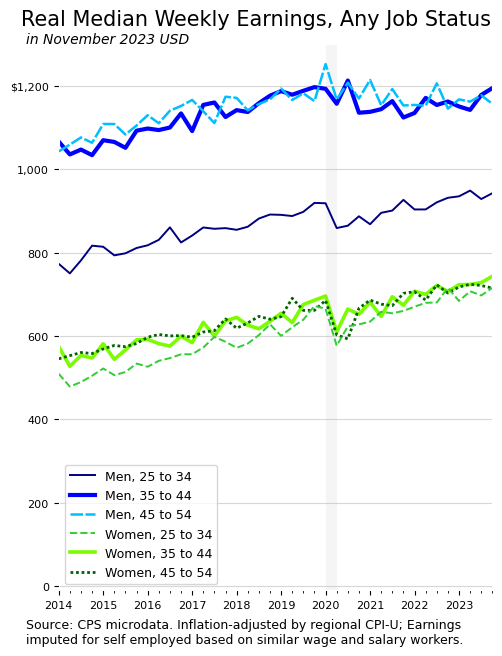

In [5]:
# Create chart
styles = ['-','-',(0,(5,1)), '--','-',(0,(1,1))]
colors = ['navy', 'blue', 'deepskyblue', 'limegreen', 'lawngreen', 'darkgreen']
linewidths = [1.4, 3.0, 1.8, 1.4, 2.6, 2.0]
zorder = [4, 2, 3, 4, 2, 3]

fig, ax = plt.subplots(figsize=(5, 6))
plt.tight_layout()
for col, color, ls, lw, z in zip(res.columns, colors, styles, linewidths, zorder):
    res[col].plot(color=color, linestyle=ls, lw=lw, ax=ax, zorder=z)
ax.set_ylim(-10, 1300)
yticks = [1200, 1000, 800, 600, 400, 200, 0]
yticklabels = ['$1,200', '1,000', '800', '600', '400', '200', '0']
plt.yticks(yticks, yticklabels)
ax.grid(True, which='major', axis='y', alpha=0.5, zorder=0)
ax.legend()
fig.text(0.02, 0.97, 'in November 2023 USD', size=10, style='italic')
fig.text(0.01, 1.00, 'Real Median Weekly Earnings, Any Job Status', size=15)
# Recession bars
for r_start, r_end in rec_dt:
    ax.axvspan(r_start, r_end, facecolor='whitesmoke', zorder=0)

# Footer
footer = ('Source: CPS microdata. Inflation-adjusted by regional CPI-U; Earnings\n'+
          'imputed for self employed based on similar wage and salary workers.')
fig.text(0.02, -0.03, footer, size=9)
plt.savefig('chart1.png', bbox_inches='tight')
plt.show()